In [1]:
import numpy as np
import networkx as nx
from scipy.linalg import eigh as eigh
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from itertools import permutations
import random
import matplotlib.pyplot as plt

# BASIC SETUP

def directed_cycle(k):
    """
    adjacency matrix of a directed k cycle
    """
    A = np.zeros((k,k))
    for i in range(k-1):
        A[i, i+1] = 1
    A[k-1, 0] = 1
    return A

def DSBM(k, n, p, q, F):
    """
    Directed Stochastic Block Model 
    (see *Hermitian matrices for clustering directed graphs: insights and applications*).
    Note: This assumes evenly sized clusters
    
    Input
     k: Number of clusters {C_1, C_2, ..., C_k}
     n: Number of vertices in each cluster
     p: probability of an edge between two vertices in the same cluster
     q: probability of an edge between two vertices in different clusters
     F: k x k matrix controlling the orientation of the edges. F_{uv} + F_{vu} = 1
     
    Return
     G: nx.DiGraph()
    """
    N = n*k
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(N))
    
    # add the edges
    for cluster in range(k):
        # do intra cluster first
        for i in range(n-1):
            u = i + n*cluster
            for j in range(i+1, n):
                v = j + n*cluster
                if np.random.rand() < p: #edge exists
                    # pick orientation uniformly at random
                    #  corresponds to diagonal of F
                    if np.random.rand() < 0.5:
                        G.add_edge(u,v)
                    else:
                        G.add_edge(v,u)
    
    # Do inter cluster now
    for clust in range(k-1):
        for other in range(clust + 1, k):
            for i in range(n):
                # get the elements in 
                u = i + n*clust
                for j in range(n):
                    #iterating through other's nodes
                    v = j + n*other
                    if np.random.rand() < q: # add edge
                        if np.random.rand() < F[clust, other]:
                            G.add_edge(u,v)
                        else:
                            G.add_edge(v,u)
                    
                    
    return G
    
    
def Hermitian_A(G):
    """
    Given directed graph G, return the matrix A_H.
    A_H(u,v) = i if edge (u,v) exists, -i if (v, u) exists, and 1 if both exist.
    Otherwise 0
    
    NOTE: Probably better to make a function that deals with adjacency list
    rather than a 2d np.array. To do later
    
    Parameters
     G: nx.DiGraph()
     
    Returns
     Ah: np.array with complex entries
    """
    A = nx.to_numpy_array(G)
    N = len(A)
    Ah = np.zeros_like(A, dtype=complex)
    for u in range(N):
        for v in range(u+1, N):
            uv = A[u,v]
            vu = A[v,u]
            if uv == 1 and vu == 0:
                Ah[u,v] = 1j
                Ah[v,u] = -1j
            if uv == 1 and vu == 1:
                Ah[u,v] = 1
                Ah[v,u] = 1
            if uv == 0 and vu == 1:
                Ah[u,v] = -1j
                Ah[v,u] = 1j
    return Ah

def Algorithm1(G, ell, n_init = 'auto', rw = False, tau=0):
    """
    Algorithm 1 as found in
    "Hermitian matrices for clustering directed graphs: insights and applications"
    
    Parameters
     G: nx.DiGraph
     ell: number of eigenpairs to use
     rw: (bool) if do random walk Hermitian A or not
     
    Returns
     partition: partition of nodes into clusters
     
    NOTES: Important imports implicit here
     eigh:    scipy.linalg.eigh
     KMeans:  sklearn.clusters.KMeans
     np:      numpy
    """
    N = len(G)
    
    if not rw:
        A = Hermitian_A(G)
        
    if rw:
        A = Hermitian_A(G)
        #d = np.abs(A)@np.ones(N) # more efficient way surely but later
        d = np.sum(np.abs(A), axis=1) # row sums of |A|
        d = d + tau
        d = d**(-1/2)
        A = np.diag(d)@A
        
        
    w, v = eigh(A, subset_by_index = [N-ell, N-1]) # w is the ell largest eigenvalues
    P = v@v.conj().T # v is N x ell matrix of ell largest eigenvectors
    
    #NOTE!!: possible difference here from paper
    #      as we don't use an \epsilon, also w has the largest, not
    #      largest magnitude. Results haven't seemed to change too much
    #      but probably good to correct at some point
    #      fixed below in Algorithm1FIXED

    
    #V = potential_v[:,np.argsort(potential_w)[:ell]]
    #P = V@V.conj().T # V is N x ell matrix of ell largest magnitude eigenvectors
        
    
    # Do kmeans on the rows of P
    # kmeans doesn't work on complex
    #  so make the dimension twice as large but real valued
    P2N = np.hstack([P.real, P.imag])
    
    kmeans = KMeans(n_clusters = ell, n_init=n_init) #consider putting a random_state in for testing
    kmeans.fit(P2N)
    
    return kmeans.labels_

def Algorithm1FIXED(G, ell, n_init = 'auto', rw = False, tau=0):
    """
    Algorithm 1 as found in
    "Hermitian matrices for clustering directed graphs: insights and applications"
    
    Parameters
     G: nx.DiGraph
     ell: number of eigenpairs to use
     rw: (bool) if do random walk Hermitian A or not
     
    Returns
     partition: partition of nodes into clusters
     
    NOTES: Important imports implicit here
     eigh:    scipy.linalg.eigh
     KMeans:  sklearn.clusters.KMeans
     np:      numpy
    """
    N = len(G)
    
    if not rw:
        A = Hermitian_A(G)
        
    if rw:
        A = Hermitian_A(G)
        #d = np.abs(A)@np.ones(N) # more efficient way surely but later
        d = np.sum(np.abs(A), axis=1) # row sums of |A|
        d = d + tau
        d = d**(-1/2)
        A = np.diag(d)@A
        
        
    w, v = eigh(A, subset_by_index = [N-ell, N-1]) # w is the ell largest eigenvalues
    #P = v@v.conj().T # v is N x ell matrix of ell largest eigenvectors
    #NOTE!!: possible difference here from paper
    #      as we don't use an \epsilon, also w has the largest, not
    #      largest magnitude. Results haven't seemed to change too much
    #      but probably good to correct at some point
    w_small, v_small = eigh(A, subset_by_index = [0, ell - 1])
    potential_w = np.concatenate((w, w_small))
    potential_v = np.hstack((v, v_small))
    
    V = potential_v[:,np.argsort(potential_w)[::-1][:ell]]
    P = V@V.conj().T # V is N x ell matrix of ell largest magnitude eigenvectors
        
    
    # Do kmeans on the rows of P
    # kmeans doesn't work on complex
    #  so make the dimension twice as large but real valued
    P2N = np.hstack([P.real, P.imag])
    
    kmeans = KMeans(n_clusters = ell, n_init=n_init) #consider putting a random_state in for testing
    kmeans.fit(P2N)
    
    return kmeans.labels_

def create_F(k,eta):
    """
    Creates F for DSBM, k x k matrix with noise level eta
    NOTE: Currently only works for directed cycle
    """
    F = np.zeros((k,k))

    # k x k adj of directed cycle (with noise)
    for j in range(k):
        for ell in range(k):
            if (j % k) == ((ell-1) % k):
                F[j, ell] = 1 - eta
            elif (j % k) == ((ell + 1)%k):
                F[j, ell] = eta
            else:
                F[j, ell] = 0.5
    return F


def DSBM_true_labels(k, n):
    """
    list (np.array) of size n*k where the first k elements are 0, then k 1s, ..., k (n-1)s
    """
    true_labels = []
    for cluster in range(k):
        for node in range(n):
            true_labels.append(cluster)
    return np.array(true_labels)


def get_cut(G, cl, i, j, score='ratio', signed = False, use_matrix = False, matrix_to_use = []):
    """
    Cut scores between cluster i and cluster j
    as in *Hermitian matrices for clustering directed graphs: insights and applications*
    
    Input
     G: nx.DiGraph
     cl: (array-like) cl[k] = cluster membership of node k
     i, j: (ints) clusters of interest (i --> j)
     score: (str) cut_score variant. 
         'ratio' -- unnormalized
         'size' -- multiplied by min of sizes of clusters i and j
         'volume' -- multiplied by min of volume of cluser i and j
     signed: (bool) If signed is False take the absolute value of the score
     use_matrix: (bool) if false scores calculated using G. If True, scores
                         calculated using an np.array (e.g. Adjacency matrix)
     matrix_to_use: (np.array) If not empty, use that matrix to calculate cut score
                                 (e.g. if want a weighted graph. can accept weighted adjacency or 
                                 weighted hermitian adjacency)/
    
    Returns:
     cut score cluster i to cluster j
     
    NOTES: probably could/should have not included use_matrix and matrix_to_use
            as currently not trying to deal with weighted graphs, just checking for
            possible bugs in code
    """
    #if (i not in np.arange(0, k)) or (j not in np.arange(0, k)):
    #    print("Clusters out of bounds: i,j must be in \{0, 1, ..., k-1\}")
    #    return 0
    X = np.where(cl == i)[0]
    Y = np.where(cl == j)[0]
    
    wXY = 0
    wYX = 0
                
    if use_matrix:
        # use an np.array to get edge data
        if len(matrix_to_use) > 0:
            A = matrix_to_use
            for vi in X:
                for vj in Y:
                    wXY += max(A[vi, vj], 0)
                    wYX += max(A[vj, vi], 0)
                    
        if len(matrix_to_use) == 0:
            # Didn't supply a matrix
            use_matrix = False
            
            
    if not use_matrix:
        # we just use graph data structure. i.e. not weighted edges
        for vi in X:
            for vj in Y:
                #print(f"x = {vi}, y = {vj}, has_edge(x,y) = {G.has_edge(vi, vj)}")
                wXY += G.has_edge(vi, vj) # adds 1 if edge exists, else adds 0
                wYX += G.has_edge(vj, vi) # similar
                
                
    # get the ratio
    # recall SCI is Signed Cut Imbalance
    try:
        SCI = wXY/(wXY + wYX) - 0.5
    except ZeroDivisionError:
        print(f"ZeroDivisionError: Cluster {i} and Cluster {j} have no edges between them?")
        return 0
    
    if score == 'ratio':
        if signed:
            return SCI
        else:
            return np.abs(SCI)
    
    
        
    if score == 'size':
        if signed:
            return SCI * min(len(X), len(Y))
        else:
            return np.abs(SCI * min(len(X), len(Y)))
        
    
    
    if score == 'vol':
        volX = 0
        volY = 0
        if use_matrix:
            for z in range(A.shape[0]):
                for x in X:
                    volX += max(A[x, z], 0)
                for y in Y:
                    volY += max(A[y, z], 0)
        else:
            for x in X:
                volX += G.degree(x)
            for y in Y:
                volY += G.degree(y)
                
        if signed:
            return SCI * min(volX, volY)
        else:
            return np.abs(SCI * min(volX, volY))
        
        
def cutscore_meta_matrix(G, cl, score='ratio', signed = False, use_matrix = False, matrix_to_use = []):
    """
    create a meta adjacency matrix with the cut score defining the weights
    
    Input
     G: nx.DiGraph
     cl: (array-like) cl[k] = cluster membership of node k
     i, j: (ints) clusters of interest (i --> j)
     score: (str) cut_score variant. 
         'ratio' -- unnormalized
         'size' -- multiplied by min of sizes of clusters i and j
         'volume' -- multiplied by min of volume of cluser i and j
     signed: (bool) If signed is False take the absolute value of the score
     use_matrix: (bool) if false scores calculated using G. If True, scores
                         calculated using an np.array (e.g. Adjacency matrix)
     matrix_to_use: (np.array) If not empty, use that matrix to calculate cut score
                                 (e.g. if want a weighted graph. can accept weighted adjacency or 
                                 weighted hermitian adjacency)
    Returns
     M: 2d np.array
     
    
    NOTE: update to use **kwargs maybe for cleaner definition?
    """
    meta_nodes = np.unique(cl)
    k = len(meta_nodes)
    M = np.zeros((k,k))
    
    # Loop through the clusters
    #  get the cut scores
    #  use those as the entries of the meta adjacency matrix
    for i in meta_nodes:
        for j in meta_nodes:
            M[i,j] = get_cut(G, cl, i, j, score=score, signed = signed, use_matrix = use_matrix, matrix_to_use = matrix_to_use)
            
    return M
            
    
def make_unweighted(M, eps = 0.2):
    """
    Convert a real skew-symmetric matrix to a 0/1 directed adjacency matrix by zeroing out entries
    small in magnitude. Eliminates negative values too.
    (M being skew-symmetric doesn't come into play in the code,
     its just the types of matrices we are using)
    
    Input:
     M: (2d np.array) real matrix (corresponding to the meta_matrix above)
     eps: (numeric) tolerance. If M[i,j] < eps set M[i,j]=0
    """
    k = M.shape[0]
    N = np.zeros((k,k))
    
    for i in range(k):
        for j in range(k):
            if M[i, j] > eps:
                N[i,j] = 1
    return N



# ALGO SPECIFIC STUFF

def find_min_perm(M, target, order = 'fro'):
    """
    Find permutation that minimizes |pi^TMpi - target|
    
    Input:
     M: (2d np.array) - given matrix (meta matrix in our case)
     target: (2d np.array) - 0/1 adjacency matrix we are hoping to recover
     order: (float or str) - ord used in np.linalg.norm (what type of matrix or vector norm)
     
    Returns:
     minperm: (tuple) - the permutation pi that minimized the distance
     minMat: (2d np.array) - the matrix that achieved the minimum
     
    Imports assumed:
     import numpy as np
     from itertools import permutations
    """
    k = target.shape[0]
    perms = list(permutations(np.arange(k)))
    
    minperm = []
    minMat = M
    mindist = np.inf # initialize to infinity
    
    for perm in perms:
        Mhat = M[list(perm)]
        Mhat = Mhat[:,list(perm)] # Mhat is M with permuted rows and columns
        currdist = np.linalg.norm(Mhat - target, ord = order)
        if currdist < mindist:
            mindist = currdist
            minperm = perm
            minMat = Mhat
            
    return minperm, minMat
        
    
def flip_edges(G, M, cl, i, j, want_meta_edge):
    """
    flip edges from cluster i to cluster j to better match what we expect in
    the target matrix (side information)
    
    Input:
     G: nx.DiGraph
     M: (2d np.array) meta_cut_matrix with score='ratio'
     cl: (array-like) clustering of G
     i, j: (int) clusters of interest. If want an edge it will be from i to j
     want_meta_edge: (bool) True--flip to create meta edge i to j (make cut score large)
                            False--flip to destroy meta edge (make cut score near 0)
    Return:
     H: (nx.DiGraph) G with some flipped edges
     
     NOTE: Assuming M[i,j] >= 0
    """
    cl1 = np.where(cl == i)[0]
    cl2 = np.where(cl == j)[0]
    H = G.copy()
    
    if not want_meta_edge:
        # e.g. i goes to j but should be random
        # flipping probability
        alpha = M[i,j]
        prob = alpha/(alpha + 0.5) # some minor algebra on explanation in 285J report page 7
        for u in cl1:
            for v in cl2:
                if H.has_edge(u, v):
                    if random.random() < prob: #random.random() \in [0, 1)
                        # flip the edge with probability prob
                        H.remove_edge(u, v)
                        H.add_edge(v, u)
                        
        return H
    
    # if we create the edge instead
    for u in cl1:
        for v in cl2:
            if H.has_edge(v, u): # has wrong orientation
                H.remove_edge(v, u)
                H.add_edge(u, v)
    return H


def meta_graph_match(G, k, target, true_labels, order='fro', maxiters = 10, rw=True, eps=0.2, **kwargs):
    """
    iteratively cluster, find best permutation to match the target meta matrix,
    flip the edges accordingly in the clusters matching the largest discrepancy
    between the current meta matrix and the target.
    (When flipping edges, we are working in a copy of G, not altering G directly)
    As described in Algorithm MGM in 285J project report
    
    NOTE: This is the function that all the previous ones were building to
    
    NOTE: for now at least, working with DSBM so we have access to the true clustering
            so calculate the ari at each stage
    
    Input: 
     G: (nx.DiGraph)
     k: (int) number of clusters
     ##M: (2d np.array) Meta Graph of cluster
     target: (2d np.array) side information (desired meta graph)
     true_labels: (array-like) the true labeling of 
     order: (str) order command for find_min_perm
     maxiters: (int) max number of iterations of 'edge fixing' we'll do
     **kwargs: same as cutscore_meta_matrix 
     
    Return:
    cl_new: the final clustering
    ari_list: list of the ari scores at each step
    """
    # maybe don't input cl, just do it here
    ari_list = []
    
    H = G.copy()
    i = 0
    while i < maxiters:
        # calculate a clustering and ari score
        C = Algorithm1(H, k, rw = rw)
        ari = adjusted_rand_score(true_labels, C)
        ari_list.append(ari)
        
        # get the meta flow matrix (i.e. adjacency from cluster cut scores)
        A = cutscore_meta_matrix(H, C, **kwargs)
        A[A < 0] = 0 # makes negative values 0, to better look like adj matrix
        B = make_unweighted(A, eps=eps) # this is possibly redundant now? I guess A still has small pos values
        
        # do the graph matching
        minperm, permA = find_min_perm(A, target, order = order)
        permB = B[list(minperm)]
        permB = permB[:,list(minperm)]
        
        # if we already have the right meta graph
        if np.max(permB - target) == 0:
            return C, ari_list, permB, minperm
        
        # i,j giving largest |permA - target|_{i,j}
        imax, jmax = np.unravel_index(np.argmax(np.abs(permA - target)), (k, k))
        
        if (permA - target)[imax, jmax] > 0:
            # i.e. we have a meta edge that we don't want 
            #  since permA_{imax, jmax} > target_{imax, jmax} so 
            #  must have permA_{imax, jmax} > 0 and target_{imax, jmax} = 0
            H = flip_edges(H, permA, C, imax, jmax, want_meta_edge=False)
            
        else:
            #(permA - target)[imax, jmax] < 0:
            # we don't have a meta edge but want i --> j
            H = flip_edges(H, permA, C, imax, jmax, want_meta_edge=True)
            
        # recluster on the updated graph
        i += 1
        
    return C, ari_list, permA, minperm
            
        
            
## DIFFERENT ALGO
def flip_unhappy_edges(G, cl, i, j):
    """
    Given a graph G, clustering cl, meta edge i-->j, 
    flip all the edges that go from j to i so they better match 
    the correct meta edge
    
    Inputs:
     G: (nx.DiGraph) -- graph of interest
     cl: (1d np.array) -- cluster membership list. cl[u] = k if node u is in cluster k
     i: (int) -- cluster i where the meta edge begins
     j: (int) -- cluster j where the meta edge ends
     
    Returns:
     H: (nx.DiGraph) -- graph with 'fixed' edges
    """
    cl1 = np.where(cl == i)[0]
    cl2 = np.where(cl == j)[0]
    H = G.copy()
    
    for u in cl1:
        for v in cl2:
            if H.has_edge(v, u):
                H.remove_edge(v, u)
                H.add_edge(u, v)
                
    return H

def iterative_small_fixes(G, target, true_labels, maxiters = 20):
    """
    cluster -> find 'most happy' meta edge -> flip_unhappy_edges
    repeat until meta graph matches target (up to permutation).
    That is, use Algorithm1 to find a cluster, C. Create a meta adjacency matrix, A,
    with entries given by cut scores. Find argmax_{ij} A_{ij}. Flip the remaining 
    edges so as to drive this particular cut score as large as possible. 
    Repeat until the meta graph matches the target meta graph or we hit our maxiters. 
    
    
    Inputs:
     G: (nx.DiGraph) -- graph of interest
     target: (2d np.array) -- (side information) 'true' adjacency matrix of meta graph
     
    Returns:
     cl_list: (list of lists) -- the clusterings at each iteration 
                                 (cl_list[k] is clustering at kth time step)
     ari_list: (list) -- the ARI score at each time step
    """
    k = target.shape[0]
    curr_iter = 0
    ari_list = []
    cl_list = []
    
    H = G.copy()
    
    while curr_iter < maxiters:
        #H = G.copy()
        
        # get a cluster and ari score 
        C = Algorithm1(H, k)
        cl_list.append(C)
        ari = adjusted_rand_score(true_labels, C)
        ari_list.append(ari)
        
        # get meta matrix of the current clustering
        A_S = cutscore_meta_matrix(H, C, score='ratio', signed = True)

        #A_S is skew-symmetric
        #  make negative values 0 to turn into directed adjacency
        A = A_S.copy()
        A[A < 0] = 0
        
        # turn A into a 0,1 matrix by setting all positive values = 1
        B = A.copy()
        B[B > 0] = 1
        
        # stop if B is the target
        minperm, permB = find_min_perm(B, target)
        if np.max(permB - target) == 0:
            return cl_list, ari_list

        # i,j index of largest entry of A
        imax, jmax = np.unravel_index(np.argmax(A), (k, k))
        
        # flip the outlier edges of this 'best' edge
        H = flip_unhappy_edges(H, C, imax, jmax)
        
        curr_iter += 1
        
    return cl_list, ari_list



#############################################
# RECLASSIFY SINGLE NODE STUFF
#############################################
def meta_edge_agreement_score(G, u, cl, meta_edge):
    """
    rate how well node u aligns with meta_edge (more positive means better)
    
    Input
     G: nx.DiGraph
     u: (int) the vertex in question
     cl: (np.array) the clustering. cl[u] = k if u is in cluster k
     meta_edge: (tuple) the meta_edge in question (e.g. (Ci, Cj))
    """
    score = 0
    C0 = meta_edge[0]
    C1 = meta_edge[1]
    
    if cl[u] == C0:
        # look for edges u --> v
        for v in G.neighbors(u):
            if cl[v] == C1:
                score += 1
        for v in G.predecessors(u):
            if cl[v] == C1:
                score -= 1
    
    if cl[u] == C1:
        # look for edges u <-- v
        for v in G.predecessors(u):
            if cl[v] == C0:
                score += 1
        for v in G.neighbors(u):
            if cl[v] == C0:
                score -= 1
        
    if cl[u] != C0 and cl[u] != C1:
        raise ValueError("node u must be in one of the clusters in the meta_edge")
    
    return score


def meta_node_agreement_score(G, u, cl, meta_edges):
    """
    do we just maximize over all of the meta_edges associated to the meta_node?
    do we normalize in some way?
    """
    total_score = 0
    
    for edge in meta_edges:
        if cl[u] in edge:
            total_score += meta_edge_agreement_score(G, u, cl, edge)
            
    return total_score


def reclassify_single_nodes_iterative(G, k, num_edges, max_iter = 10, get_ari_each_step = True, true_labels = []):
    """
    Seek to improve Clustering given by Herm(G, k) by trying to
    reclassify nodes one at a time by seeking for a meta node (community)
    they better agree with.
    Begin by using Herm(G,k) and then make the implied meta matrix but
    keep only the num_edges largest positive values
    
    Inputs:
     G - nx.DiGraph
     k - (int) Number of clusters
     num_edges - (int) Number of edges we know ahead of time are in the meta graph
     max_iter - (int) Max number of times to try to reclassify a node
     get_ari_each_step - (bool)
     true_labels - (list) list of ints where true_labels[i] = k if node i is in cluster k
     
    Returns:
     C - (list) the new clustering
     the_ari_scores - (list) the ari_scores calculated at each step.
     
    Note: Assumes nodes are numbered 0, 1, ..., len(G) - 1
    """
    N = len(G)
    C = Algorithm1FIXED(G, k)
    M_0 = cutscore_meta_matrix(G, C, signed=True)
    
    if get_ari_each_step and len(true_labels) == N:
        the_ari_scores = [adjusted_rand_score(true_labels, C)]
    
    # find the largest entries
    M_0_1d = np.ravel(M_0)
    big_entry_index = np.argsort(np.ravel(M_0))[::-1][:num_edges]
    M = np.zeros_like(M_0_1d)
    M[big_entry_index] = M_0_1d[big_entry_index]
    M = M.reshape(M_0.shape)
    
    # the edges the first cluster decided we have
    meta_edges = [tuple(e) for e in np.argwhere(M > 0)]
    
    curr_iter = 0
    while curr_iter < max_iter:
        # rank the nodes unhappiest to happiest
        node_happiness = []
        for i in range(N):
            Ci = C[i]
            Ci_edges = [e for e in meta_edges if Ci in e]
            node_happiness.append(meta_node_agreement_score(G, i, C, Ci_edges))
            
        u_sad = np.argmin(node_happiness)
        C_sad = C[u_sad]
        
        # find a better fit for u_sad
        happiest_cluster = C_sad
        happiest_score = node_happiness[u_sad]
        for clust in range(k):
            C_temp = [num for num in C]
            C_temp[u_sad] = clust
            clust_edges = [e for e in meta_edges if clust in e]
            curr_score = meta_node_agreement_score(G, u_sad, C_temp, clust_edges)
            if curr_score > happiest_score:
                happiest_cluster = clust
                happiest_score = curr_score
                
        # No change :(
        if C_sad == happiest_cluster:
            if get_ari_each_step:# and len(true_labels) > 0:
                return C, the_ari_scores
            return C
        
        # make the change in cluster membership
        C[u_sad] = happiest_cluster
        if get_ari_each_step:# and len(true_labels) == N:
            the_ari_scores.append(adjusted_rand_score(true_labels, C))
        
        curr_iter += 1
        if curr_iter > max_iter:
            break
    if get_ari_each_step:# and len(true_labels) == N:
        return C, the_ari_scores
    return C


def reclassify_single_nodes_iterativeV2(G, k, num_edges, max_iter = 10, get_ari_each_step = True, true_labels = []):
    """
    Seek to improve Clustering given by Herm(G, k) by trying to
    reclassify nodes one at a time by seeking for a meta node (community)
    they better agree with.
    Begin by using Herm(G,k) and then make the implied meta matrix but
    keep only the num_edges largest positive values
    
    V2: Here we recalculate the implied meta matrix after each reassignment
    
    Inputs:
     G - nx.DiGraph
     k - (int) Number of clusters
     num_edges - (int) Number of edges we know ahead of time are in the meta graph
     max_iter - (int) Max number of times to try to reclassify a node
     get_ari_each_step - (bool)
     true_labels - (list) list of ints where true_labels[i] = k if node i is in cluster k
     
    Returns:
     C - (list) the new clustering
     the_ari_scores - (list) the ari_scores calculated at each step.
     
    Note: Assumes nodes are numbered 0, 1, ..., len(G) - 1
    """
    N = len(G)
    C = Algorithm1FIXED(G, k)
    M_0 = cutscore_meta_matrix(G, C, signed=True)
    
    # want the ARI score and provided some true labels to compare with
    if get_ari_each_step and len(true_labels) == N:
        the_ari_scores = [adjusted_rand_score(true_labels, C)]
    
    # find the largest entries
    M_0_1d = np.ravel(M_0)
    big_entry_index = np.argsort(np.ravel(M_0))[::-1][:num_edges]
    M = np.zeros_like(M_0_1d)
    M[big_entry_index] = M_0_1d[big_entry_index]
    M = M.reshape(M_0.shape)
    
    # the edges the first cluster decided we have
    meta_edges = [tuple(e) for e in np.argwhere(M > 0)]
    
    curr_iter = 0
    while curr_iter < max_iter:
        # score the nodes on how happy or unhappy they are
        #  in their current cluster assignment
        node_happiness = []
        for i in range(N):
            Ci = C[i]
            Ci_edges = [e for e in meta_edges if Ci in e]
            node_happiness.append(meta_node_agreement_score(G, i, C, Ci_edges))
            
        u_sad = np.argmin(node_happiness)
        C_sad = C[u_sad]
        
        # find a better fit for u_sad
        happiest_cluster = C_sad
        happiest_score = node_happiness[u_sad]
        for clust in range(k):
            C_temp = [num for num in C]
            C_temp[u_sad] = clust
            clust_edges = [e for e in meta_edges if clust in e]
            curr_score = meta_node_agreement_score(G, u_sad, C_temp, clust_edges)
            if curr_score > happiest_score:
                happiest_cluster = clust
                happiest_score = curr_score
                
        # No change :( Most unhappy node is already in its best possible cluster
        if C_sad == happiest_cluster:
            if get_ari_each_step:# and len(true_labels) > 0:
                return C, the_ari_scores
            return C
        
        # make the change in cluster membership
        C[u_sad] = happiest_cluster
        if get_ari_each_step:# and len(true_labels) == N:
            the_ari_scores.append(adjusted_rand_score(true_labels, C))
        
        # This version: Update the meta matrix too
        M_0 = cutscore_meta_matrix(G, C, signed=True)
        M_0_1d = np.ravel(M_0)
        big_entry_index = np.argsort(np.ravel(M_0))[::-1][:num_edges]
        M = np.zeros_like(M_0_1d)
        M[big_entry_index] = M_0_1d[big_entry_index]
        M = M.reshape(M_0.shape)
        meta_edges = [tuple(e) for e in np.argwhere(M > 0)]
        
        # Hit maximum iterations?
        curr_iter += 1
        if curr_iter > max_iter:
            break
    if get_ari_each_step:# and len(true_labels) == N:
        return C, the_ari_scores
    return C




### Things I'll want to keep track of for this
- the graph
- clusters at each step
- ARI at each step
- which node was updated?

In [44]:
# Alter code to track that info
def reclassify_single_nodes_iterative_TRACK(G, k, num_edges, max_iter = 10, get_ari_each_step = True, true_labels = []):
    """
    Seek to improve Clustering given by Herm(G, k) by trying to
    reclassify nodes one at a time by seeking for a meta node (community)
    they better agree with.
    Begin by using Herm(G,k) and then make the implied meta matrix but
    keep only the num_edges largest positive values
    
    Inputs:
     G - nx.DiGraph
     k - (int) Number of clusters
     num_edges - (int) Number of edges we know ahead of time are in the meta graph
     max_iter - (int) Max number of times to try to reclassify a node
     get_ari_each_step - (bool)
     true_labels - (list) list of ints where true_labels[i] = k if node i is in cluster k
     
    Returns:
     C - (list) the new clustering
     the_ari_scores - (list) the ari_scores calculated at each step.
     
    Note: Assumes nodes are numbered 0, 1, ..., len(G) - 1
    
    NEW: This returns a list of the clusters, the ari_scores, 
    what node changed at what step, where it went,
    old happy score vs new happy score, the neighbors of the moved nodes,
    the implied meta matrix
    
    NOTE: In this notebook I added to this function as it went,
          Consequently, some of the first cells will have this
          function returning fewer things.
          Be aware of this if you try to just copy and paste
          some cells to run more experiments
    """
    N = len(G)
    C = Algorithm1FIXED(G, k)
    M_0 = cutscore_meta_matrix(G, C, signed=True)
    
    if get_ari_each_step and len(true_labels) == N:
        the_ari_scores = [adjusted_rand_score(true_labels, C)]
        
    the_nodes_moved = []
    the_moves_made = []
    the_clusters = [[num for num in C]]
    before_after_happy_scores = []
    neighbors_of_moved = []
    
    # find the largest entries
    M_0_1d = np.ravel(M_0)
    big_entry_index = np.argsort(np.ravel(M_0))[::-1][:num_edges]
    M = np.zeros_like(M_0_1d)
    M[big_entry_index] = M_0_1d[big_entry_index]
    M = M.reshape(M_0.shape)
    
    # the edges the first cluster decided we have
    meta_edges = [tuple(e) for e in np.argwhere(M > 0)]
    
    curr_iter = 0
    while curr_iter < max_iter:
        # rank the nodes unhappiest to happiest
        node_happiness = []
        for i in range(N):
            Ci = C[i]
            Ci_edges = [e for e in meta_edges if Ci in e]
            node_happiness.append(meta_node_agreement_score(G, i, C, Ci_edges))
            
        # find the node with smallest agreement score
        u_sad = np.argmin(node_happiness)
        C_sad = C[u_sad]
        
        # append information to other info we are returning
        #  to test and understand the algorithm
        the_nodes_moved.append(u_sad)
        the_moves_made.append([C_sad, -1])
        before_after_happy_scores.append([np.min(node_happiness), np.inf])
        neighbors_of_moved.append([list(G.neighbors(u_sad)), list(G.predecessors(u_sad))])
        
        # find a better fit for u_sad
        happiest_cluster = C_sad
        happiest_score = node_happiness[u_sad]
        for clust in range(k):
            C_temp = [num for num in C]
            C_temp[u_sad] = clust
            clust_edges = [e for e in meta_edges if clust in e]
            curr_score = meta_node_agreement_score(G, u_sad, C_temp, clust_edges)
            if curr_score > happiest_score:
                happiest_cluster = clust
                happiest_score = curr_score
                
        the_moves_made[-1][1] = happiest_cluster
        #the_clusters.append([num for num in C])
        # No change :(
        if C_sad == happiest_cluster:
            if get_ari_each_step:# and len(true_labels) > 0:
                return the_clusters, the_ari_scores, the_nodes_moved, the_moves_made, before_after_happy_scores, neighbors_of_moved, M
            return C
        
        # make the change in cluster membership
        C[u_sad] = happiest_cluster
        the_clusters.append([num for num in C])
        before_after_happy_scores[-1][1] = happiest_score
        if get_ari_each_step:# and len(true_labels) == N:
            the_ari_scores.append(adjusted_rand_score(true_labels, C))
        
        # Have we done too many rounds?
        curr_iter += 1
        if curr_iter > max_iter:
            break
            
    if get_ari_each_step:# and len(true_labels) == N:
        return the_clusters, the_ari_scores, the_nodes_moved, the_moves_made, before_after_happy_scores, neighbors_of_moved, M
    return C

ARI_List for graph 1:  [0.9800838361096267, 0.9850377307840942]
Nodes moved: [89] from cluster i to j: [[0, 1]]

ARI_List for graph 2:  [0.9900168347249766, 0.9949958125176231]
Nodes moved: [535] from cluster i to j: [[0, 2]]

ARI_List for graph 3:  [1.0]
Nodes moved: [108] from cluster i to j: [[2, 2]]

ARI_List for graph 4:  [1.0]
Nodes moved: [507] from cluster i to j: [[0, 0]]

ARI_List for graph 5:  [0.9949958125176231]
Nodes moved: [33] from cluster i to j: [[2, 2]]

ARI_List for graph 6:  [1.0]
Nodes moved: [402] from cluster i to j: [[1, 1]]

ARI_List for graph 7:  [0.9949958125176231]
Nodes moved: [87] from cluster i to j: [[0, 0]]

ARI_List for graph 8:  [1.0]
Nodes moved: [77] from cluster i to j: [[1, 1]]

ARI_List for graph 9:  [0.9949958125176231, 1.0]
Nodes moved: [269] from cluster i to j: [[2, 1]]

ARI_List for graph 10:  [0.9949958125176231, 1.0]
Nodes moved: [167] from cluster i to j: [[2, 0]]



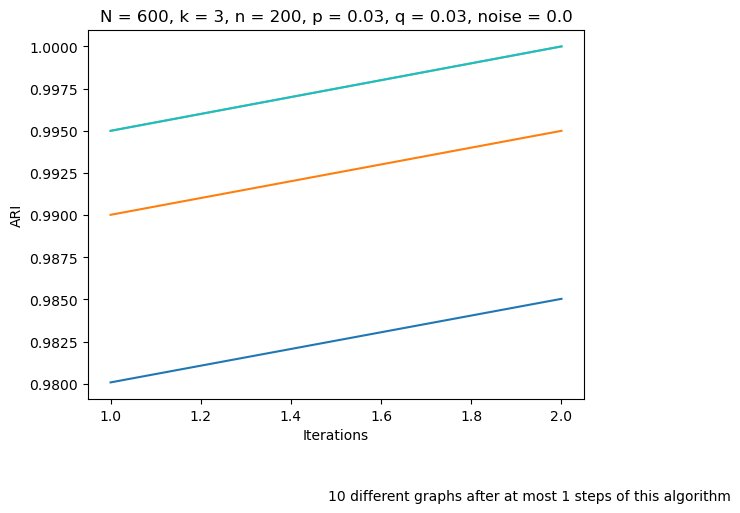

In [3]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 10
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}\n")
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9751797317603417, 0.9800961264798698]
Nodes moved: [4] from cluster i to j: [[2, 1]]

Original Clustering: [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

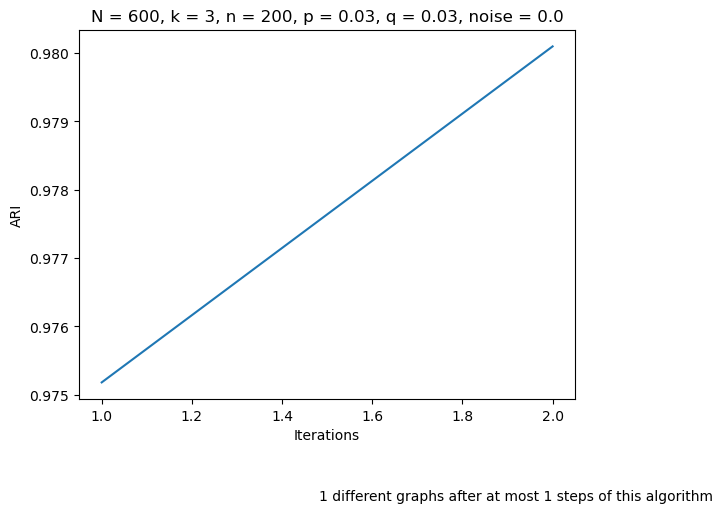

In [17]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}\n")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9949958125176231, 1.0]
Nodes moved: [3] from cluster i to j: [[2, 0]]

Original Clustering: [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

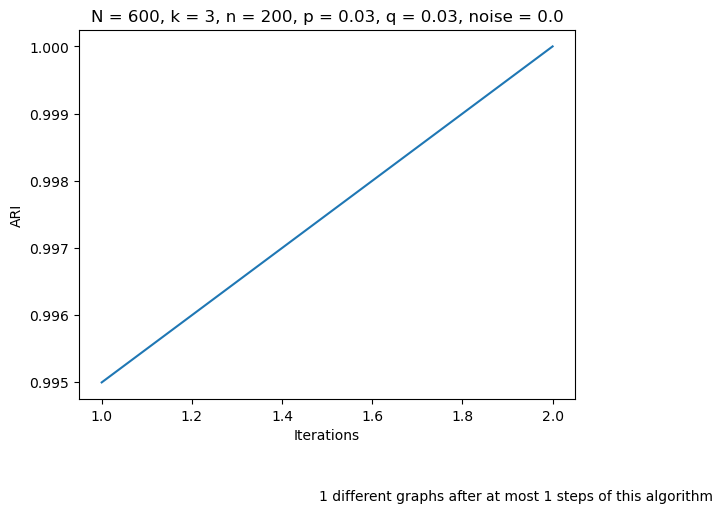

In [21]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}\n")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.985037604845926, 0.9900166666666667]
Nodes moved: [536] from cluster i to j: [[0, 2]]. Score changed: [[0, 3]]

Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2

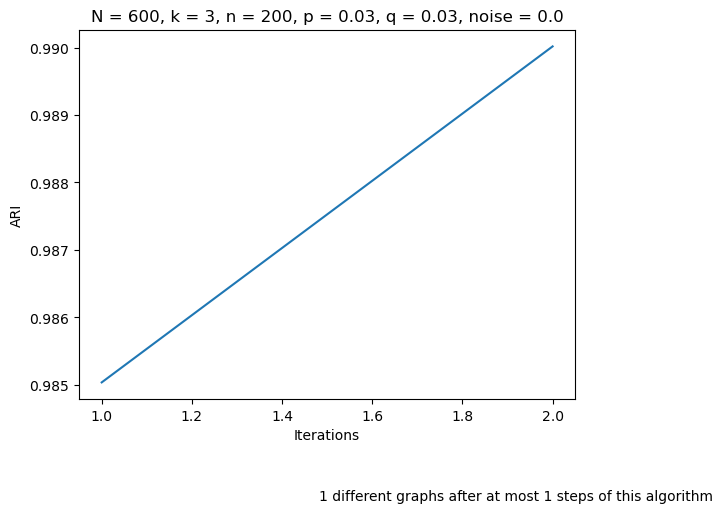

In [27]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9949958125176231, 1.0]
Nodes moved: [546] from cluster i to j: [[2, 0]]. Score changed: [[1, 8]]

Out neighbors of node: [445, 477, 481, 490, 495, 538, 12, 36, 191]
In neighbors of node: [410, 544, 210, 248, 295, 304, 342]
Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

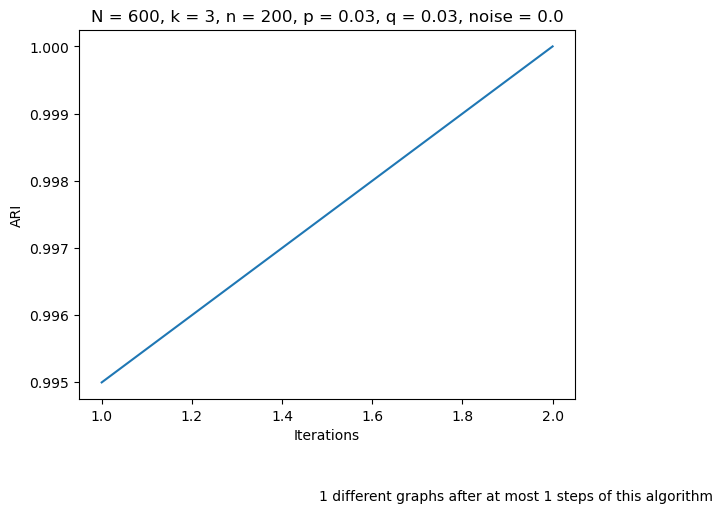

In [38]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



# Pay attention to here (and one other place I'll point out)
### Explanation of above example:
The true meta graph should be a cycle: $1\to2\to0\to1$

Node 546 initially put in cluster 2, then it was updated to be in cluster 0. It had the following edges:

pointed to 6 nodes in cluster 0: (445, 477, 481, 490, 495, 538)

pointed to 3 nodes in cluster 1: (12, 36, 191)

incoming edge 2 nodes in cluster 0: (410, 544)

incoming edge 5 nodes in cluster 2: (210, 248, 295, 304, 342)

#### Thoughts
It seems $\operatorname{Herm}(G, 3)$ might have seen the largest quanity of edges were directed to cluster 0 so it figured that was the strongest/most important signal. Hence put node 546 in the cluster that points to 0 (i.e. cluster 2).

So it seems like even though there was contradictory information about edges between cluster 0 (that is, in edges *and* out edges between node546 and cluster 0) there was still somehow the "most" information about that meta edge so node546 got placed in cluster 2 (since cluster 2 was largely defined by its relation to cluster 0).

Then, once we "know" what the meta edges are, we can then adjust node546 to a cluster better suited for it.

ARI_List for graph 1:  [0.42104941397227713, 0.41977261043897207]
Nodes moved: [213] from cluster i to j: [[2, 1]]. Score changed: [[-12, -5]]

Out neighbors of node: [287, 295, 321, 335, 337, 390, 459, 480, 520, 530, 552, 555, 567, 569, 595, 598]
In neighbors of node: [285, 309, 382, 399, 4, 34, 62, 118, 122, 125, 126, 138, 168, 175, 178]
(Original) implied meta matrix:
 [[0.         0.         0.01694393]
 [0.01515152 0.         0.0122807 ]
 [0.         0.         0.        ]]
Original Clustering: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

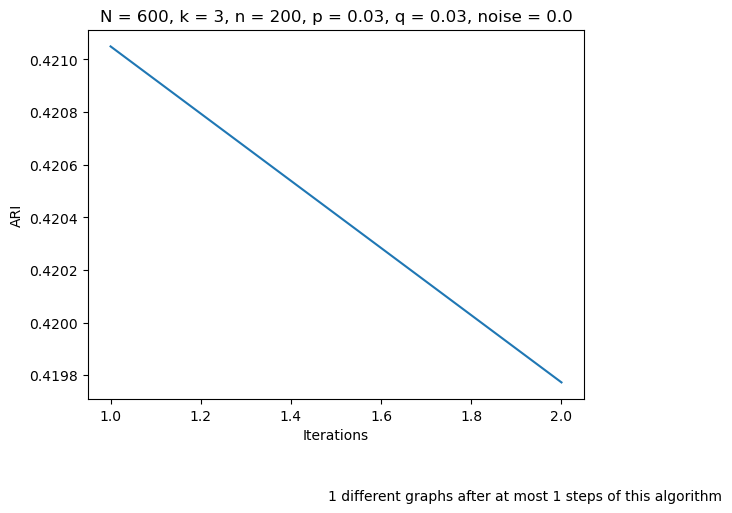

In [47]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"(Original) implied meta matrix:\n {M}")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



# Pay attention to here too
(The rest of this notebook is examples but these two are the most clear I think)
#### Above example commentary
When the clustering starts out bad this algorithm seems to make things worse.

What seems plausible is happening to me is that 
**if we don't find important edges** then this algorithm tries to better match things up with unimportant information, driving ARI down as we prioritize the wrong edges.

This suggests that **this reclassifying single nodes algorithm may perform well if we know the meta graph, but not as well otherwise.**

This could possibly be made better by either
- keeping more than just the $k$ "best" edges in our implied meta matrix
    - allows us to possibly use important edge information that previously would have been accidentally discarded
    - weighting the happiness scores by the implied meta matrix weights
    - keeping all edges with weights in implied meta matrix over some threshold
- use this approach in the meta graph matching schemes
    - If we know the true underlying meta graph, find the closest match of implied meta matrix. From there do the node happiness scoring using the edges that should exist?
- Recalculating the implied meta matrix after every round (or few rounds?) to hope that these node changes change the implied meta matrix enough that different edges are found? (hopefully the correct ones)

ARI_List for graph 1:  [0.9949958125176231, 1.0]
Nodes moved: [501] from cluster i to j: [[1, 2]]. Score changed: [[1, 4]]

Out neighbors of node: [400, 439, 462, 506, 552, 38]
In neighbors of node: [405, 450, 457, 480, 484, 509, 532, 556, 570, 217, 218, 333]
(Original) implied meta matrix:
 [[0.         0.         0.5       ]
 [0.49737762 0.         0.        ]
 [0.         0.49559083 0.        ]]
Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

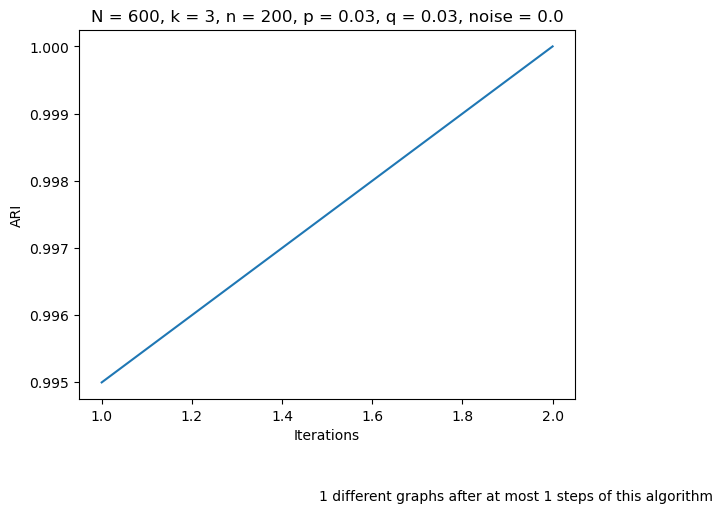

In [48]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.00

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"(Original) implied meta matrix:\n {M}")
    print(f"Original Clustering:", np.array(the_clusters[0]))
    print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9949958125176231, 1.0]
Nodes moved: [502] from cluster i to j: [[0, 2]]. Score changed: [[2, 6]]

Out neighbors of node: [450, 479, 522, 155]
In neighbors of node: [330, 339, 342, 363, 374]

(Original) implied meta matrix:
 [[0.         0.         0.49079498]
 [0.48901099 0.         0.        ]
 [0.         0.49093157 0.        ]]

Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

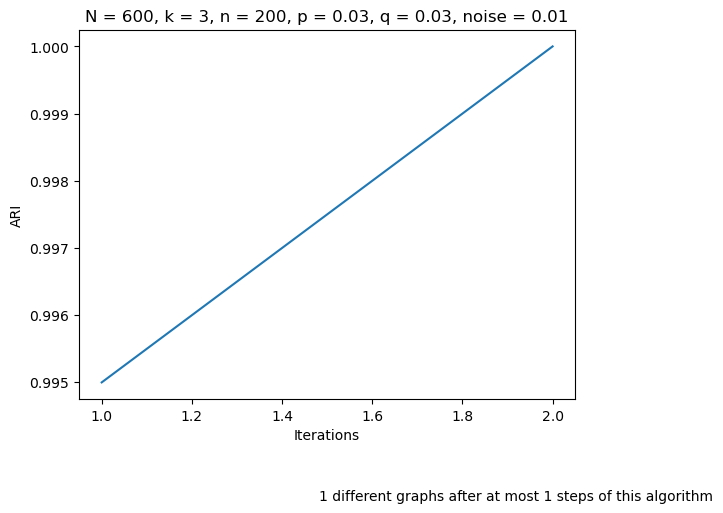

In [52]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.01

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9900041668585104, 0.9949958125176231]
Nodes moved: [40] from cluster i to j: [[1, 0]]. Score changed: [[-1, 3]]

Out neighbors of node: [29, 100, 160, 258]
In neighbors of node: [25, 35, 166, 181, 570, 574]

(Original) implied meta matrix:
 [[0.         0.46891192 0.        ]
 [0.         0.         0.47886179]
 [0.48626817 0.         0.        ]]

Original Clustering: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1

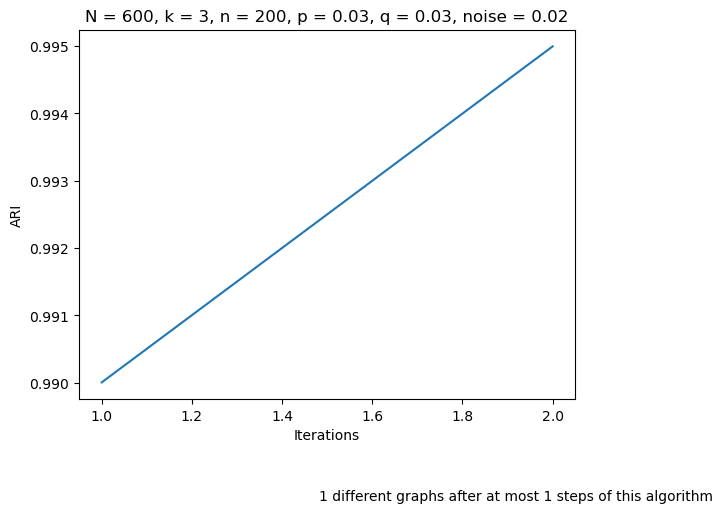

In [53]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.02

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9949958125176231, 1.0]
Nodes moved: [385] from cluster i to j: [[1, 2]]. Score changed: [[-1, 1]]

Out neighbors of node: [319, 398, 174, 189, 540]
In neighbors of node: [228, 239, 146, 190]

(Original) implied meta matrix:
 [[0.         0.4688     0.        ]
 [0.         0.         0.44987469]
 [0.45623987 0.         0.        ]]

Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2

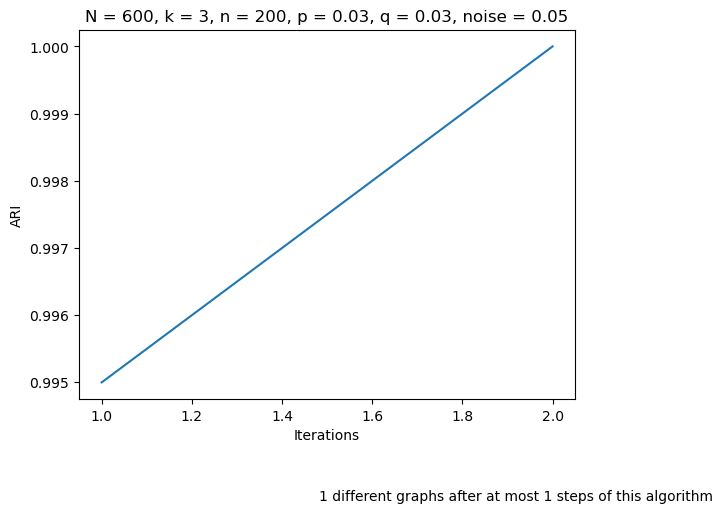

In [54]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.05

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.9555927678228577, 0.9604726645695939]
Nodes moved: [571] from cluster i to j: [[0, 2]]. Score changed: [[-2, 4]]

Out neighbors of node: [446, 455, 16, 161, 235]
In neighbors of node: [438, 448, 474, 486, 491, 20, 33, 60, 216, 239, 290, 303, 381, 393]

(Original) implied meta matrix:
 [[0.         0.39291465 0.        ]
 [0.         0.         0.39789303]
 [0.4009901  0.         0.        ]]

Original Clustering: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

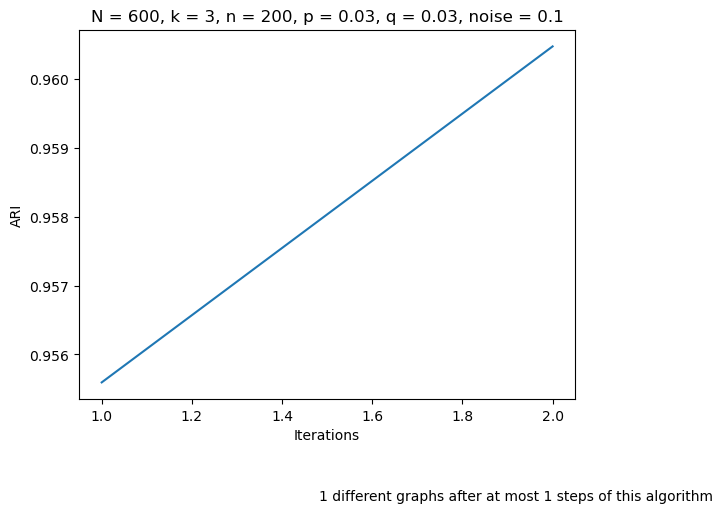

In [55]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.1

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.7913705410685368, 0.7959041525656079]
Nodes moved: [464] from cluster i to j: [[1, 0]]. Score changed: [[-5, 4]]

Out neighbors of node: [456, 519, 572, 40, 126, 222]
In neighbors of node: [470, 546, 548, 569, 217, 302, 322, 331, 385]

(Original) implied meta matrix:
 [[0.         0.32713915 0.        ]
 [0.         0.         0.33386838]
 [0.34163987 0.         0.        ]]

Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

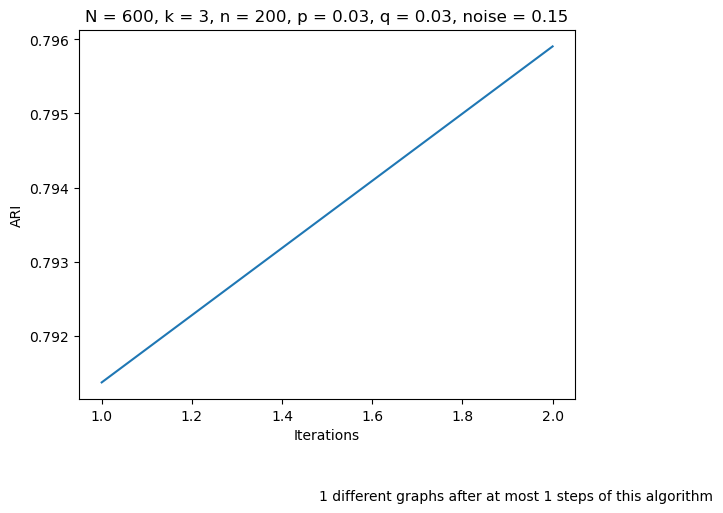

In [56]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.15

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.5719551599440972, 0.572023075157681]
Nodes moved: [107] from cluster i to j: [[2, 0]]. Score changed: [[-4, 2]]

Out neighbors of node: [155, 362, 476, 497, 530]
In neighbors of node: [74, 113, 126, 146, 152, 170, 326, 419, 457, 502, 532]

(Original) implied meta matrix:
 [[0.         0.         0.28243978]
 [0.27836412 0.         0.        ]
 [0.         0.26769359 0.        ]]

Original Clustering: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 2 1 1 1 2 1 1 1 0 1 2 1 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 2 0 1 1 1 1 1
 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 1 1 2 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 2 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 0 1 1 1 0 1 1 1 2 1 1 1 1 1 1 0 1 1 1 2 1
 1 1 1 1 1 1 1 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 2 2 1 2 1 1
 1 1 1 1 1 1 0 1 2 1 1 1 1 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 

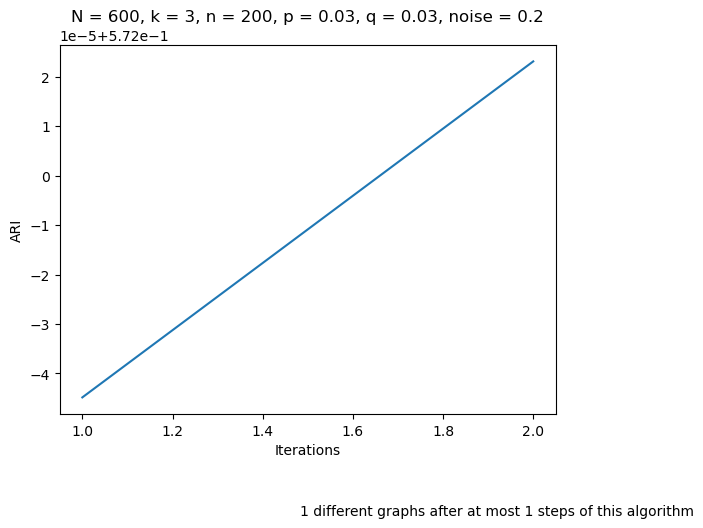

In [57]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.2

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.29596232426154695, 0.29889741847796414]
Nodes moved: [267] from cluster i to j: [[2, 0]]. Score changed: [[-8, 5]]

Out neighbors of node: [219, 258, 43, 128, 400, 432, 444, 446, 456, 458, 497, 550, 569]
In neighbors of node: [212, 225, 249, 357, 51, 55, 68, 170, 418, 443, 530]

(Original) implied meta matrix:
 [[0.         0.27230769 0.        ]
 [0.         0.         0.17814476]
 [0.18599034 0.         0.        ]]

Original Clustering: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 0 2 0 2 2 0 2 2 2 2 1 2 0 2 2 2 1 2 2 2 2 2 2 1 2 1 1 2 1 2 2 1 2 1
 2 2 0 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 0 1 2 2 2 2 0 2 2 1 2 2 2 2 0 2 2 2 2
 2 1 0 2 2 2 0 2 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0 1 2 0 0 0 0 2 0 0 2
 0 0 1 0 0 0 2 0 0 0 0 1 0 0 0 0 1 2 2 0 1 0 0 0 1 0 0 0 1 0 2 1 1 2 0 0 0
 0 0 

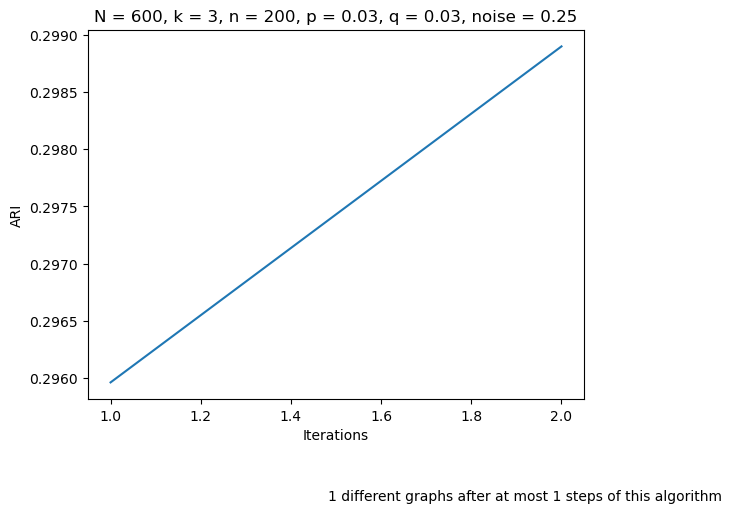

In [58]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.25

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.0012434053259835526, 0.0012442879871999858]
Nodes moved: [455] from cluster i to j: [[1, 2]]. Score changed: [[-12, 9]]

Out neighbors of node: [414, 453, 499, 89, 119, 176, 190, 255, 336, 344]
In neighbors of node: [484, 546, 53, 87, 185, 213, 229, 323, 345, 365, 367, 377, 391]

(Original) implied meta matrix:
 [[0.         0.         0.13174114]
 [0.1559633  0.         0.        ]
 [0.         0.15630397 0.        ]]

Original Clustering: [2 0 1 2 0 1 0 1 1 0 1 2 1 1 2 2 0 0 0 2 1 0 2 2 1 0 2 0 0 0 1 2 0 0 0 2 1
 2 0 0 1 1 2 1 1 0 0 1 2 0 1 2 2 2 0 1 1 2 2 2 1 2 0 0 1 1 0 0 1 2 2 1 2 1
 2 1 1 2 0 0 1 1 0 1 1 2 0 2 0 2 1 2 0 2 2 2 1 0 1 0 0 1 2 2 0 1 1 2 1 1 0
 2 2 2 0 2 0 2 1 1 2 1 2 0 1 1 0 0 2 2 1 0 0 2 1 0 2 2 0 1 2 2 1 0 0 1 2 0
 2 2 1 1 0 1 0 2 0 2 0 0 0 0 2 0 0 2 0 0 2 1 1 1 2 0 2 2 2 0 1 1 2 0 1 1 0
 0 1 0 0 1 1 1 0 2 1 0 0 0 2 1 0 0 0 0 0 1 2 1 2 2 0 0 0 1 2 1 2 0 1 2 0 2
 0 2 1 2 1 1 1 0 2 1 2 2 2 0 1 2 2 0 0 2 0 2 0 0 2 0 2 0 0 0 2 1 1 2 2 0 2
 1 0

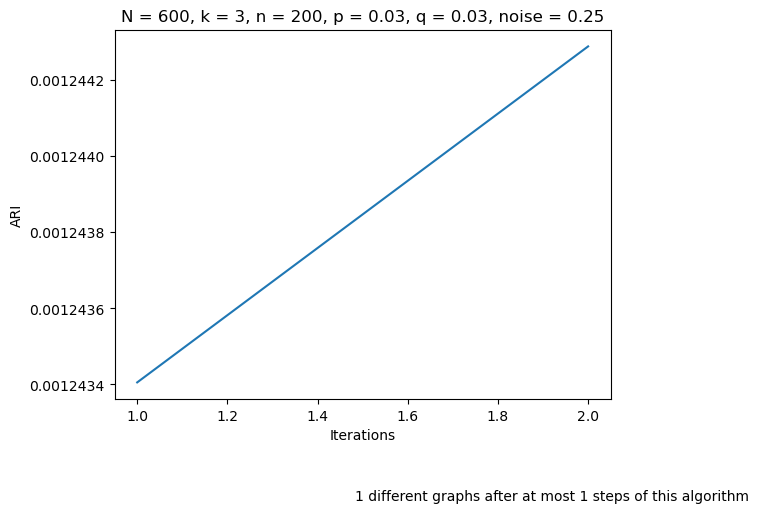

In [59]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.25

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.1305152486212615, 0.1326035962402005, 0.13422057098502765, 0.13502722404808745, 0.13753404067352082, 0.13589077125890303, 0.135110260454067, 0.13589077125890303, 0.13670389663918595, 0.13836511761219006, 0.13745907839869234, 0.13964030353888446, 0.13915491718779002, 0.13870158998049079, 0.1403535345411242, 0.13871661778513875, 0.13960557151955974, 0.13840643314128198, 0.1368007045653852, 0.13840643314128198, 0.13752657509664198]
Nodes moved: [293, 489, 356, 29, 428, 265, 277, 299, 515, 176, 322, 439, 475, 536, 186, 355, 539, 15, 90, 219] from cluster i to j: [[0, 1], [1, 2], [2, 1], [2, 0], [2, 1], [1, 2], [2, 1], [2, 1], [1, 2], [1, 2], [0, 1], [0, 1], [0, 1], [1, 2], [0, 1], [2, 1], [2, 0], [0, 1], [1, 0], [1, 2]]. Score changed: [[-16, 13], [-14, 13], [-13, 14], [-11, 14], [-11, 11], [-10, 10], [-10, 8], [-10, 12], [-10, 12], [-9, 6], [-9, 14], [-9, 8], [-9, 8], [-9, 6], [-8, 9], [-8, 12], [-8, 9], [-7, 10], [-7, 6], [-7, 7]]

Out neighbors of node: [203, 2

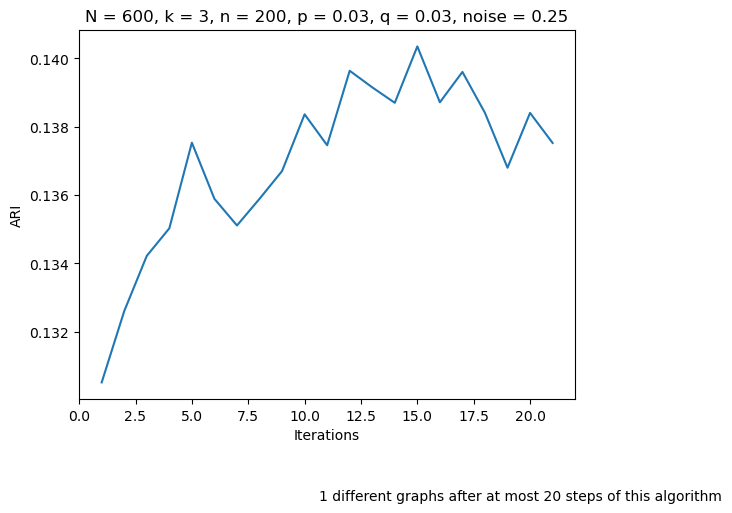

In [60]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.25

max_iter = 20
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    print(f"Out neighbors of node: {nhbrs[0][0]}")
    print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.28564595435123113, 0.2832026319795413, 0.2829989451825698, 0.28013826785593693, 0.28280727870652383, 0.28264667903359825, 0.28535003637934403, 0.2824549460993005, 0.28229428840944804, 0.2794455568645642, 0.27675793970002677, 0.27922532933823374, 0.27655983122054584, 0.2737836219248497, 0.2710386560986543, 0.2682942307159979, 0.2655809564591717, 0.2628989025791099, 0.2655380683980955, 0.2655809564591717, 0.26823598232826, 0.2707445368263933, 0.2680686392964561, 0.27066759171862553, 0.2680686392964561, 0.26810799031853877, 0.2680558863943902, 0.2680349977933248, 0.2680453325262678, 0.270710379062303, 0.27336520105933315, 0.2759896781667668, 0.27326950948616363, 0.27336520105933315, 0.2706607640979769, 0.26798749010813927, 0.270540492312662, 0.26798749010813927, 0.2706807575013514, 0.27075704224430835, 0.27079772391058504, 0.27071196778028234, 0.27342730837040174, 0.27071196778028234]

(Original) implied meta matrix:
 [[0.         0.         0.20212766]
 [0.23223

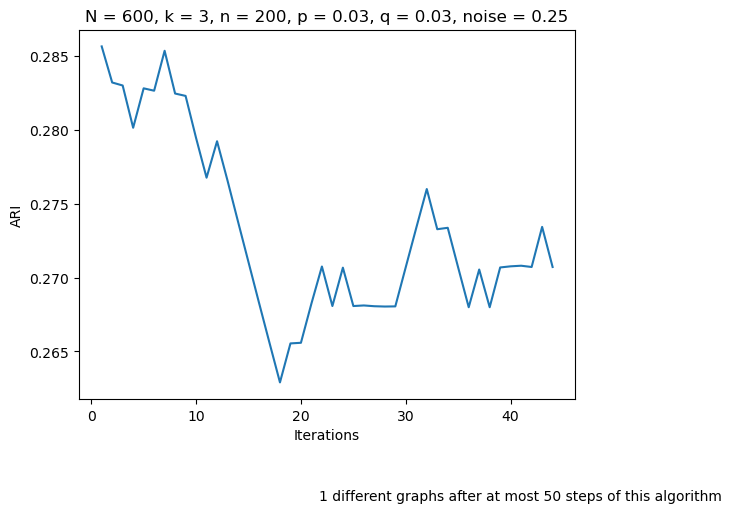

In [61]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.25

max_iter = 50
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    #print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    #print(f"Out neighbors of node: {nhbrs[0][0]}")
    #print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[-1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.7730420003856097, 0.7775322637983727, 0.7820447566098461, 0.7865850995737612, 0.7910814911745484, 0.7956053548758246, 0.8001515378029199, 0.8047252045326052, 0.809326245849012, 0.8138440473621644, 0.8183888748943527, 0.8229252321839386, 0.8183888748943527, 0.8229252321839386, 0.8275089989829845]

(Original) implied meta matrix:
 [[0.         0.         0.34615385]
 [0.31561997 0.         0.        ]
 [0.         0.33835846 0.        ]]

Original Clustering: [2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2
 1 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 1 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1

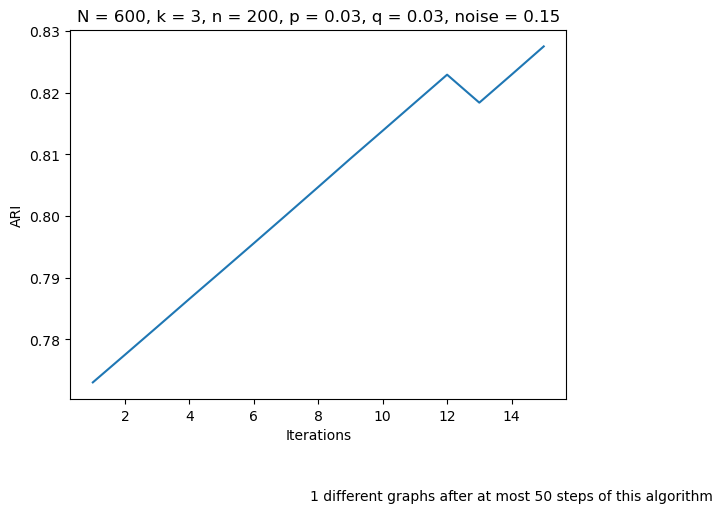

In [63]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.15

max_iter = 50
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    #print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    #print(f"Out neighbors of node: {nhbrs[0][0]}")
    #print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[-1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.04009764350516497, 0.04120498425607553, 0.04141314117376142, 0.040674280583323445, 0.03943201811768206, 0.038740390025271174, 0.03943972812984918, 0.04070713645557202, 0.04200745572038465, 0.04182468729578511, 0.04167429488037842, 0.04183277478259104, 0.04274090319122968, 0.04368226096033128, 0.04242803283151181, 0.041156849150347515, 0.04100461116230417, 0.04225992363996227, 0.04100461116230417, 0.04194546939505606, 0.04271174018608723, 0.043510301762818504, 0.04370221465355893, 0.04247072214241268, 0.04127060275919395, 0.04010193394982135, 0.04052399369673501, 0.03980958506120426, 0.04087236086657136, 0.041968862207504475, 0.042927513930089437, 0.04391941015796867, 0.044786374523642584, 0.04568566019989335, 0.04674353921777178, 0.04690264747932893, 0.04783463933712041, 0.04895895903156581, 0.05011649511699027, 0.049151859341555026, 0.049377621674802794, 0.04814886275097976, 0.04784427885184875, 0.04747256791228953, 0.046282569472525174, 0.04762215784382457, 

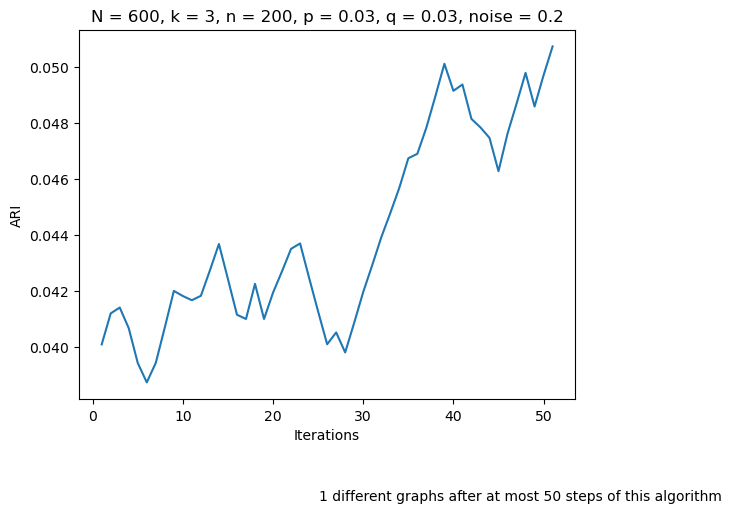

In [64]:
# Look at different densities
k = 3
n = 200
p = .03
q = p
eta = 0.2

max_iter = 50
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    #print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    #print(f"Out neighbors of node: {nhbrs[0][0]}")
    #print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[-1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.7389473684210527, 0.7475936837256042]

(Original) implied meta matrix:
 [[0.         0.        ]
 [0.45717506 0.        ]]

Original Clustering: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
New clustering:  

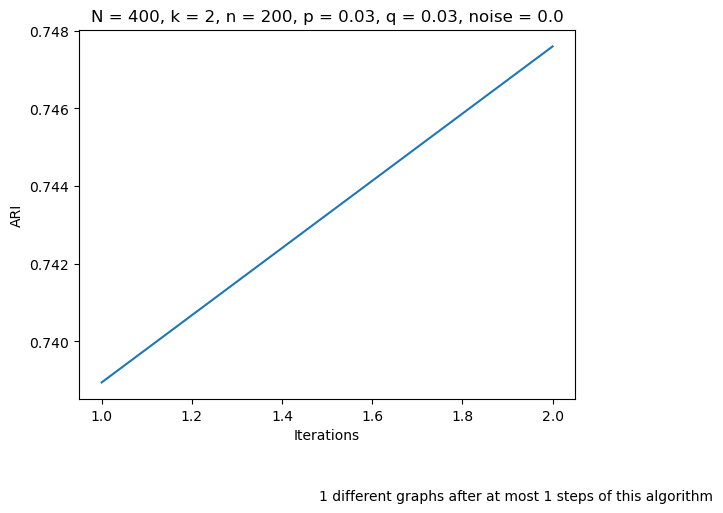

In [65]:
## CHeck on k=2 case

# Look at different densities
k = 2
n = 200
p = .03
q = p
eta = 0.0

max_iter = 1
num_samples = 1
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    #print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    #print(f"Out neighbors of node: {nhbrs[0][0]}")
    #print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    if len(the_clusters) > 1:
        print("New clustering: ", np.array(the_clusters[-1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()



ARI_List for graph 1:  [0.7303500133699338, 0.7389463189656104]

(Original) implied meta matrix:
 [[0.         0.        ]
 [0.45930671 0.        ]]
ARI_List for graph 2:  [0.024825496370172496, 0.026507991063756658]

(Original) implied meta matrix:
 [[0.        0.1056338]
 [0.        0.       ]]
ARI_List for graph 3:  [0.7303552978478315, 0.738951041448654]

(Original) implied meta matrix:
 [[0.         0.        ]
 [0.45398773 0.        ]]
ARI_List for graph 4:  [0.7389489425883953, 0.7475959667655451]

(Original) implied meta matrix:
 [[0.         0.45946999]
 [0.         0.        ]]
ARI_List for graph 5:  [0.029984442461226755, 0.031812113208199]

(Original) implied meta matrix:
 [[0.         0.        ]
 [0.10772532 0.        ]]
ARI_List for graph 6:  [0.6798241792865249, 0.6881195954991136]

(Original) implied meta matrix:
 [[0.        0.4605989]
 [0.        0.       ]]
ARI_List for graph 7:  [0.6311023166276604, 0.6390969282535548]

(Original) implied meta matrix:
 [[0.        

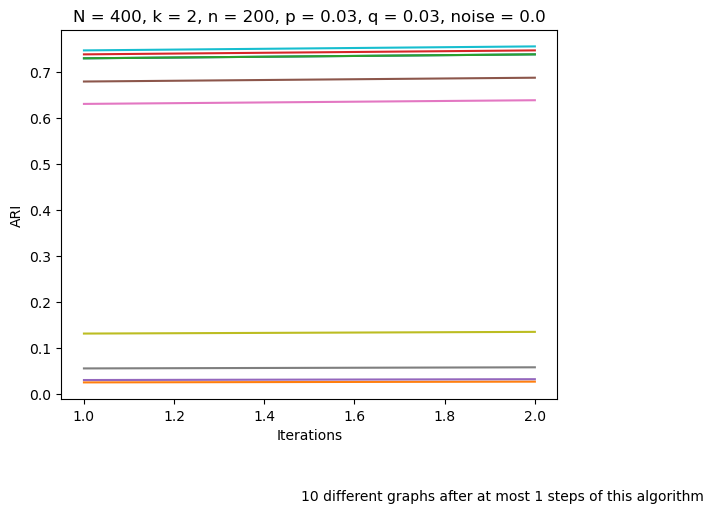

In [67]:
## CHeck on k=2 case

# Look at different densities
k = 2
n = 200
p = .03
q = p
eta = 0.0

max_iter = 1
num_samples = 10
for graph in range(num_samples):
    G = DSBM(k, n, p, q, create_F(k, eta))
    the_clusters, ari_list, nodes_moved, moves_made, scorechange, nhbrs, M = reclassify_single_nodes_iterative_TRACK(G, k, num_edges=k, max_iter = max_iter, get_ari_each_step = True, true_labels=DSBM_true_labels(k, n))

    plt.plot(np.arange(1, len(ari_list) + 1), ari_list)
    print(f"ARI_List for graph {graph + 1}: ", ari_list)
    #print(f"Nodes moved: {nodes_moved} from cluster i to j: {moves_made}. Score changed: {scorechange}\n")
    #print(f"Out neighbors of node: {nhbrs[0][0]}")
    #print(f"In neighbors of node: {nhbrs[0][1]}")
    print(f"\n(Original) implied meta matrix:\n {M}")
    #print(f"\nOriginal Clustering:", np.array(the_clusters[0]))
    #if len(the_clusters) > 1:
    #    print("New clustering: ", np.array(the_clusters[-1]))
    
plt.ylabel("ARI")
plt.xlabel("Iterations")
plt.title(f"N = {k*n}, k = {k}, n = {n}, p = {p}, q = {q}, noise = {eta}")
plt.figtext(0.5, -0.1, f"{num_samples} different graphs after at most {max_iter} steps of this algorithm")
plt.show()

